In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from datetime import datetime
pd.set_option('display.max_colwidth', None)
sns.set()

GK_GREEN = '#21B534'
GK_GREEN_LIGHT = '#07f596'
GK_PURPLE = '#7494EA'
GK_BLUE = '#19535F'
RED = "#f55b5b"
DARK_RED = "#db0000"
GREY = "#a6a6a6"
BLUE = "#4287f5"
LIGHT_GREEN = '#88D39B'

COLOUR_PALETTE = sns.color_palette('Greens_r')
GK_GREEN = COLOUR_PALETTE[1]
TWO_COLOUR_PALETTE = [GK_GREEN, GK_PURPLE]
THREE_COLOUR_PALETTE = [GK_GREEN, GK_PURPLE, GK_BLUE]
FOUR_COLOUR_PALETTE = THREE_COLOUR_PALETTE + [LIGHT_GREEN]

MAJOR_RELEASE_TYPE = 'major'
MINOR_RELEASE_TYPE = 'minor'
PATCH_RELEASE_TYPE = 'patch'
NA_RELEASE_TYPE = pd.NA

PLOTS_PATH = './plots'

### Load Data

In [2]:
issues = pd.read_csv('./csv/aug_greenkeeper_issues.csv')
comments = pd.read_csv('./csv/greenkeeper_comments.csv')
events = pd.read_csv('./csv/greenkeeper_events.csv')
commits = pd.read_csv('./csv/aug_greenkeeper_commits.csv')
package_names = pd.read_csv('./csv/greenkeeper_package_names.csv')
library_versions = pd.read_csv('./csv/aug_breaking_library_versions.csv')
library_releases = pd.read_csv('./csv/breaking_library_releases.csv')

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,16,17,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
unique_package_count = len(issues['issue_repo_url'].unique())
print(f"{len(issues)} Greenkeeper Breaking Build issue reports (across {unique_package_count} unique projects)")
print(f"{len(comments)} comments for those issue reports")
print(f"{len(events)} events on those issue reports")
# print(f"\tIncludes {events['event_description'].unique()}")
print(f"{len(commits)} commits that were referenced in these breaking issue reports")
print(f"Total of {len(library_versions)} version release records for libraries that have at least 1 breaking release")
print(f"Release frequency information on {len(library_releases)} libraries")

123197 Greenkeeper Breaking Build issue reports (across 12134 unique projects)
365625 comments for those issue reports
209750 events on those issue reports
17623 commits that were referenced in these breaking issue reports
Total of 556742 version release records for libraries that have at least 1 breaking release
Release frequency information on 7361 libraries


#### Custome Helper Functions

In [4]:
def get_issue(id):
    return issues[issues['issue_id'] == id]

def get_issue_url(id):
    return issues[issues['issue_id'] == id]['issue_url']

def get_comment(id):
    return comments[comments['comment_id'] == id]

def get_comments_for_issue(id):
    return comments[comments['comment_issue_id'] == id]

def get_event(id):
    return events[events['event_id'] == id]

def calculate_percent(numer, denom):
    return round((numer/denom)*100, 2)

def get_update_type(prev_ver, new_ver):
    if pd.isnull(prev_ver) or pd.isnull(new_ver):
        return NA_RELEASE_TYPE
    try:
        prev_split = prev_ver.split('.')
        new_split = new_ver.split('.')
        if int(new_split[0]) > int(prev_split[0]):
            return MAJOR_RELEASE_TYPE
        elif int(new_split[1]) > int(prev_split[1]):
            return MINOR_RELEASE_TYPE
        else:
            return PATCH_RELEASE_TYPE
    except Exception as e:
        return NA_RELEASE_TYPE
    
def get_issue_id_for_commit(commit):
    try:
        event_id = commit.commit_event_id
        event = get_event(event_id)
        if event.size == 0:
            return np.nan
        issue = get_issue(event.event_issue_id.values[0].astype(np.int64))
        if issue.size == 0:
            return np.nan
        return issue.issue_id.values[0].astype(np.int64)
    except Exception:
        return np.nan
    
def strfdelta(tdelta, fmt):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

def save_plot(plot, file_name, dpi=400):
    plot.savefig(f'{PLOTS_PATH}/{file_name}', dpi=400)

#### Augment Data

In [5]:
events['event_description'] = events['event_description'].astype('category')
issues["issue_created_at"] = issues["issue_created_at"].astype("datetime64")
issues["issue_updated_at"] = issues["issue_updated_at"].astype("datetime64")
issues["issue_closed_at"] = issues["issue_closed_at"].astype("datetime64")
issues['update_type'] = issues['update_type'].astype('category')
library_releases["first_release_date"] = library_releases["first_release_date"].astype("datetime64")
library_releases["last_release_date"] = library_releases["last_release_date"].astype("datetime64")

library_releases["avg_time_between_releases"] = \
    pd.to_timedelta(library_releases["avg_time_between_releases"])

comments['comment_created_at'] = pd.to_datetime(comments['comment_created_at'])
comments['comment_updated_at'] = pd.to_datetime(comments['comment_updated_at'])
comments['comment_user_type'] = comments['comment_user_type'].astype('category')

## What types of updates are breaking client's builds?

### Total counts of breaking update types
TODO: Look into extracting the rest

In [6]:
sns.set()
issues_with_update_type_count = len(issues[~(issues['update_type'].isnull())])
percent_with_update_type = calculate_percent(issues_with_update_type_count, len(issues))

major_break_count = len(issues[issues['update_type'] == 'major'])
minor_break_count = len(issues[issues['update_type'] == 'minor'])
patch_break_count = len(issues[issues['update_type'] == 'patch'])

major_break_percent = calculate_percent(major_break_count, issues_with_update_type_count)
minor_break_percent = calculate_percent(minor_break_count, issues_with_update_type_count)
patch_break_percent = calculate_percent(patch_break_count, issues_with_update_type_count)


print(f"{percent_with_update_type}% ({issues_with_update_type_count}) of Greenkeeper issues could have their update type extracted.")

print(f"\t{major_break_percent}% ({major_break_count}) are major breaking updates")
print(f"\t{minor_break_percent}% ({minor_break_count}) are minor breaking updates")
print(f"\t{patch_break_percent}% ({patch_break_count}) are patch breaking updates")


63.77% (78562) of Greenkeeper issues could have their update type extracted.
	0.16% (122) are major breaking updates
	34.69% (27254) are minor breaking updates
	65.15% (51186) are patch breaking updates


### Proportion of breaking update types

In [344]:
all_library_updates_count = len(library_versions[~(library_versions['version_release_type'].isnull())])
major_all_library_updates_count = len(library_versions[library_versions['version_release_type'] == MAJOR_RELEASE_TYPE])
minor_all_library_updates_count = len(library_versions[library_versions['version_release_type'] == MINOR_RELEASE_TYPE])
patch_all_library_updates_count = len(library_versions[library_versions['version_release_type'] == PATCH_RELEASE_TYPE])

major_all_library_percent = calculate_percent(major_all_library_updates_count, all_library_updates_count)
minor_all_library_percent = calculate_percent(minor_all_library_updates_count, all_library_updates_count)
patch_all_library_percent = calculate_percent(patch_all_library_updates_count, all_library_updates_count)


print(f"{all_library_updates_count} releases could have an explicit release type assigned")
print(f"\t{major_all_library_percent}% ({major_all_library_updates_count}) are major updates")
print(f"\t{minor_all_library_percent}% ({minor_all_library_updates_count}) are minor updates")
print(f"\t{patch_all_library_percent}% ({patch_all_library_updates_count}) are patch updates")

376927 releases could have an explicit release type assigned
	7.37% (27794) are major updates
	28.25% (106491) are minor updates
	64.37% (242642) are patch updates


In [437]:
value_type = ['Breakages', 'Breakages', 'Breakages', 'Releases', 'Releases', 'Releases', 'Breakages/Releases', 'Breakages/Releases', 'Breakages/Releases']
update_types = ['Patch', 'Minor', 'Major', 'Patch', 'Minor', 'Major', 'Patch', 'Minor', 'Major']
value = [
    patch_break_count/issues_with_update_type_count,
    minor_break_count/issues_with_update_type_count,
    major_break_count/issues_with_update_type_count,
    patch_all_library_updates_count/all_library_updates_count,
    minor_all_library_updates_count/all_library_updates_count,
    major_all_library_updates_count/all_library_updates_count,
    patch_break_count/patch_all_library_updates_count,
    minor_break_count/minor_all_library_updates_count,
    major_break_count/major_all_library_updates_count,
]
rq1_for_plot = pd.DataFrame({
    'value_type': value_type,
    'update_type': update_types,
    'value': value,
})
rq1_for_plot['value_type'] = rq1_for_plot['value_type'].astype('category')
rq1_for_plot['update_type'] = rq1_for_plot['update_type'].astype('category')

<ipython-input-438-682320047d04>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  bp.set_yticklabels(y_labels)


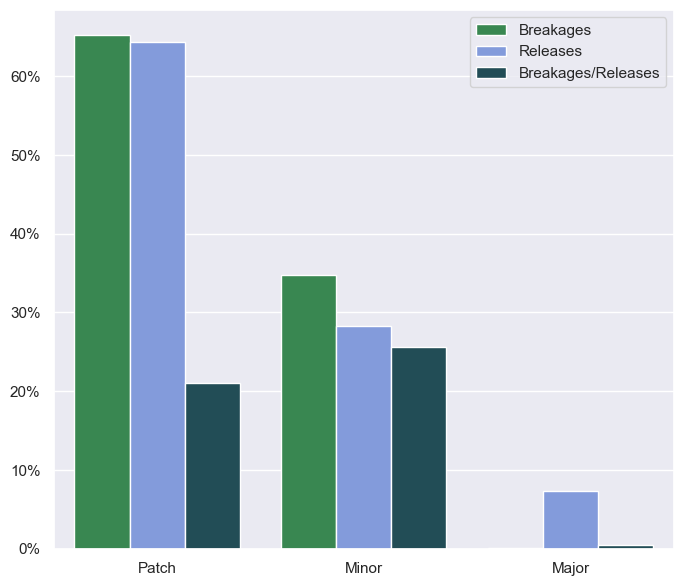

In [438]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 7))


params = dict(
    data=rq1_for_plot,
    x="update_type",
    y='value',
    hue='value_type',
    order=['Patch', 'Minor', 'Major'],
    hue_order=['Breakages', 'Releases', 'Breakages/Releases'],
)
bp = sns.barplot(
    **params,
    palette=THREE_COLOUR_PALETTE,
)

ax.set_title(f'', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('', fontsize=20)

y_labels = [f"{int(y*100)}%" for y in bp.get_yticks()]
bp.set_yticklabels(y_labels)

ax.legend(
    title="",
    fancybox=True
)
plt.show()
save_plot(bp.get_figure(), 'breakages_and_releases_ratios.png')

## Comparing Specifying Versioning Practices

### How many dependencies do packages have?

In [416]:
import json

deps_dtos = list()
for index, row in package_names.iterrows():
    deps_str = row['package_dependencies']
    if pd.isna(deps_str):
        deps = dict()
    else:
        deps = json.loads(deps_str.replace("'", '"')) if ~pd.isna(deps_str) else dict()

    dev_deps_str = row['package_dev_dependencies']
    if pd.isna(dev_deps_str):
        dev_deps = dict()
    else:
        dev_deps = json.loads(dev_deps_str.replace("'", '"')) if dev_deps_str else dict()
    deps_dtos.append({
        'package_name': row['package_name'],
        'deps': deps,
        'dev_deps': dev_deps,
    })
    
DEP = 'Dependency'
DEV_DEP = 'Dev Dependency'
packages = list()
deps_names = list()
deps_versions = list()
deps_types =  list()

for deps_dto in deps_dtos:
    package = deps_dto['package_name']
    for dep_name, dep_version in deps_dto['deps'].items():
        packages.append(package)
        deps_names.append(dep_name)
        deps_versions.append(dep_version)
        deps_types.append(DEP)
    for dep_name, dep_version in deps_dto['dev_deps'].items():
        packages.append(package)
        deps_names.append(dep_name)
        deps_versions.append(dep_version)
        deps_types.append(DEV_DEP)
        
dependencies_df = pd.DataFrame({
    'package': packages,
    'deps_name': deps_names,
    'deps_version': deps_versions,
    'deps_type': deps_types,
})


grouped_deps = dependencies_df.groupby(by=['package', 'deps_type'])['deps_name'].count().reset_index(name='count')
# TODO: Print numeric values of how many deps packages have
# grouped_deps

### How do clients specify the update types they can accept?

In [417]:
# For testing regex
# 13.4.9
# 10.1.1
# 0.1.92
# 16.13.1
# 1.0.1-RC.1
# 1.0.0-beta.30
# <2.0.0
# < 2.0.0
# ^0.0.1


# ~13.2.4
# 13.2.x
# 13.2.*
# 2.3
# ^0.1.2

# ^13.2.4
# 13.x
# 13.*
# 2.*.*
# 2
# 2

# *
# x
# >=20.0.0
# latest

regex_pinned = '^([<=]?\d+.\d+.\d+)|(^\^0.0.\d+$)'
regex_patch_release = '(^=?(\~|\d+.\d+.[x*]$)|^\d+.\d+$)|(^\^0.[1-9]\d*)'
regex_minor_release = '^=?(\^|\d+.([x*].)*[x*]$)|^\d+$'
regex_major_release = '^[\*x]$|^latest$|^>=|x.x|x.x.x'
dependencies_df['accpected_update_type'] = 'Other'

dependencies_df.loc[
    dependencies_df['deps_version'].str.contains(regex_patch_release, regex=True),
    'accpected_update_type'
] = 'Patch'

dependencies_df.loc[
    dependencies_df['deps_version'].str.contains(regex_minor_release, regex=True),
    'accpected_update_type'
] = 'Minor'

dependencies_df.loc[
    dependencies_df['deps_version'].str.contains(regex_major_release, regex=True),
    'accpected_update_type'
] = 'Major'

dependencies_df.loc[
    dependencies_df['deps_version'].str.contains(regex_pinned, regex=True),
    'accpected_update_type'
] = 'Pinned'

dependencies_df['accpected_update_type'] = dependencies_df['accpected_update_type'].astype('category')

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [434]:
deps_count = len(dependencies_df[dependencies_df['deps_type'] == 'Dependency'])
dev_deps_count = len(dependencies_df[dependencies_df['deps_type'] == 'Dev Dependency'])
# Deps
deps_pinned_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dependency') &
        (dependencies_df['accpected_update_type'] == 'Pinned')
    ]
)
deps_patch_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dependency') &
        (dependencies_df['accpected_update_type'] == 'Patch')
    ]
)
deps_minor_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dependency') &
        (dependencies_df['accpected_update_type'] == 'Minor')
    ]
)
deps_major_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dependency') &
        (dependencies_df['accpected_update_type'] == 'Major')
    ]
)

# Dev Deps
dev_deps_pinned_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dev Dependency') &
        (dependencies_df['accpected_update_type'] == 'Pinned')
    ]
)
dev_deps_patch_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dev Dependency') &
        (dependencies_df['accpected_update_type'] == 'Patch')
    ]
)
dev_deps_minor_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dev Dependency') &
        (dependencies_df['accpected_update_type'] == 'Minor')
    ]
)
dev_deps_major_count = len(
    dependencies_df[
        (dependencies_df['deps_type'] == 'Dev Dependency') &
        (dependencies_df['accpected_update_type'] == 'Major')
    ]
)

# All Deps
all_deps_pinned_count = len(
    dependencies_df[
        (dependencies_df['accpected_update_type'] == 'Pinned')
    ]
)
all_deps_patch_count = len(
    dependencies_df[
        (dependencies_df['accpected_update_type'] == 'Patch')
    ]
)
all_deps_minor_count = len(
    dependencies_df[
        (dependencies_df['accpected_update_type'] == 'Minor')
    ]
)
all_deps_major_count = len(
    dependencies_df[
        (dependencies_df['accpected_update_type'] == 'Major')
    ]
)

deps_pinned_rat = deps_pinned_count / deps_count
deps_patch_rat = deps_patch_count / deps_count
deps_minor_rat = deps_minor_count / deps_count
deps_major_rat = deps_major_count / deps_count

dev_deps_pinned_rat = dev_deps_pinned_count / dev_deps_count
dev_deps_patch_rat = dev_deps_patch_count / dev_deps_count
dev_deps_minor_rat = dev_deps_minor_count / dev_deps_count
dev_deps_major_rat = dev_deps_major_count / dev_deps_count

all_deps_pinned_rat = all_deps_pinned_count / (dev_deps_count + deps_count)
all_deps_patch_rat = all_deps_patch_count / (dev_deps_count + deps_count)
all_deps_minor_rat = all_deps_minor_count / (dev_deps_count + deps_count)
all_deps_major_rat = all_deps_major_count / (dev_deps_count + deps_count)

ratios = pd.DataFrame({
    'deps_type': ['Dependency', 'Dependency', 'Dependency', 'Dependency', 'Dev Dependency', 'Dev Dependency', 'Dev Dependency', 'Dev Dependency'],
    'accpected_update_type': ['Pinned', 'Patch', 'Minor', 'Major', 'Pinned', 'Patch', 'Minor', 'Major'],
    'ratio': [deps_pinned_rat, deps_patch_rat, deps_minor_rat, deps_major_rat, dev_deps_pinned_rat, dev_deps_patch_rat, dev_deps_minor_rat, dev_deps_major_rat]
})

all_ratios = pd.DataFrame({
    'accpected_update_type': ['Pinned', 'Patch', 'Minor', 'Major'],
    'ratio': [all_deps_pinned_rat, all_deps_patch_rat, all_deps_minor_rat, all_deps_major_rat]

})

print(f'{deps_count} Dependencies and {dev_deps_count} Dev Dependencoes')
print(f'\t{deps_pinned_count + dev_deps_pinned_count} ({round(all_deps_pinned_rat*100)}%) Pinned')
print(f'\t{deps_patch_count + dev_deps_patch_count} ({round(all_deps_patch_rat*100)}%) Patch')
print(f'\t{deps_minor_count + dev_deps_minor_count} ({round(all_deps_minor_rat*100)}%) Minor')
print(f'\t{deps_major_count + dev_deps_major_count} ({round(all_deps_major_rat*100)}%) Major')

# print(f'\t{} Patch')
# print(f'\t{} Patch')


80573 Dependencies and 192925 Dev Dependencoes
	34256 (13%) Pinned
	10224 (4%) Patch
	225125 (82%) Minor
	2951 (1%) Major


<ipython-input-426-a89cd915a695>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_yticklabels(y_labels, fontsize=16)
<ipython-input-426-a89cd915a695>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_yticklabels(y_labels, fontsize=16)


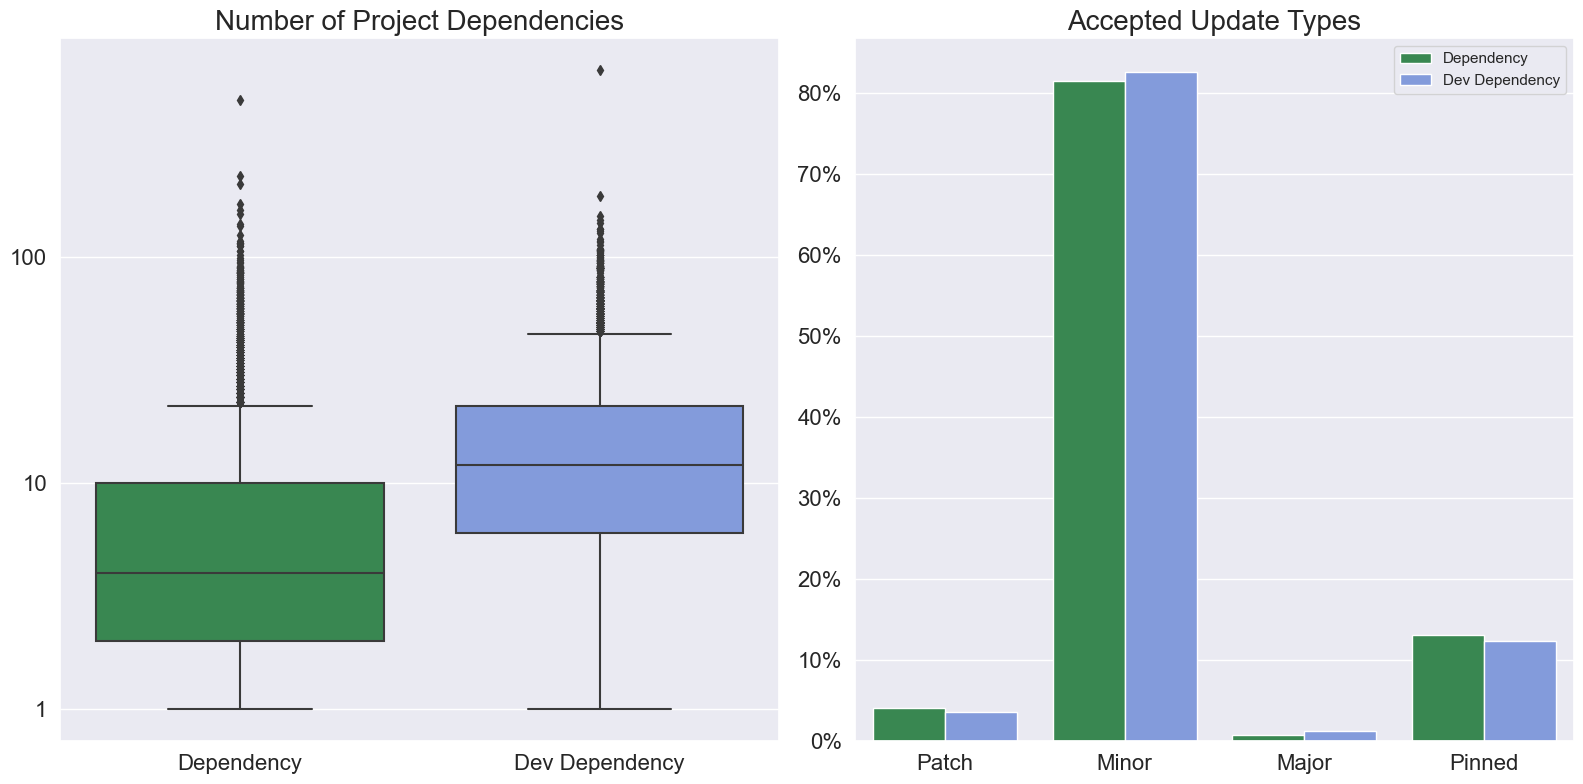

In [426]:
sns.set()
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
deps_type_order = ['Dependency', 'Dev Dependency']

params_1 = dict(
    data=grouped_deps,
    x='deps_type',
    y='count',
    order=deps_type_order,
)
ax_1 = sns.boxplot(
    **params_1,
    palette=TWO_COLOUR_PALETTE,
    ax=ax_1
)

ax_1.set_yscale("log")
ax_1.set_title(f'Number of Project Dependencies', fontsize=20)
ax_1.set_ylabel('', fontsize=20)
ax_1.set_xlabel('', fontsize=20)
y_labels = [f"{int(x)}" for x in ax_1.get_yticks()]
ax_1.set_yticklabels(y_labels, fontsize=16)
ax_1.set_xticklabels(ax_1.get_xticklabels(), fontsize=16)

params_2 = dict(
    data=ratios,
    x='accpected_update_type',
    y='ratio',
    hue='deps_type',
    order=['Patch', 'Minor', 'Major', 'Pinned'],
    hue_order=deps_type_order,
)
ax_2 = sns.barplot(
    **params_2,
    palette=TWO_COLOUR_PALETTE,
    ax=ax_2,
)
ax_2.set_title(f'Accepted Update Types', fontsize=20)
ax_2.set_ylabel('', fontsize=20)
ax_2.set_xlabel('', fontsize=20)
y_labels = [f"{int(x*100)}%" for x in ax_2.get_yticks()]
ax_2.set_yticklabels(y_labels, fontsize=16)
ax_2.set_xticklabels(ax_2.get_xticklabels(), fontsize=16)
ax_2.legend(
    title="",
    fancybox=True
)
fig.tight_layout()
plt.show()
save_plot(fig, 'accpected_update_types.png')

In [476]:
all_ratios_to_add_rq1 = pd.DataFrame({
    'value_type': 'Accepted Update Types',
    'update_type': all_ratios['accpected_update_type'],
    'value': all_ratios['ratio'],
})
rq1_for_plot_aug = rq1_for_plot.append(all_ratios_to_add_rq1, ignore_index=True)


<ipython-input-479-f6883869cf12>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels, fontsize=16)


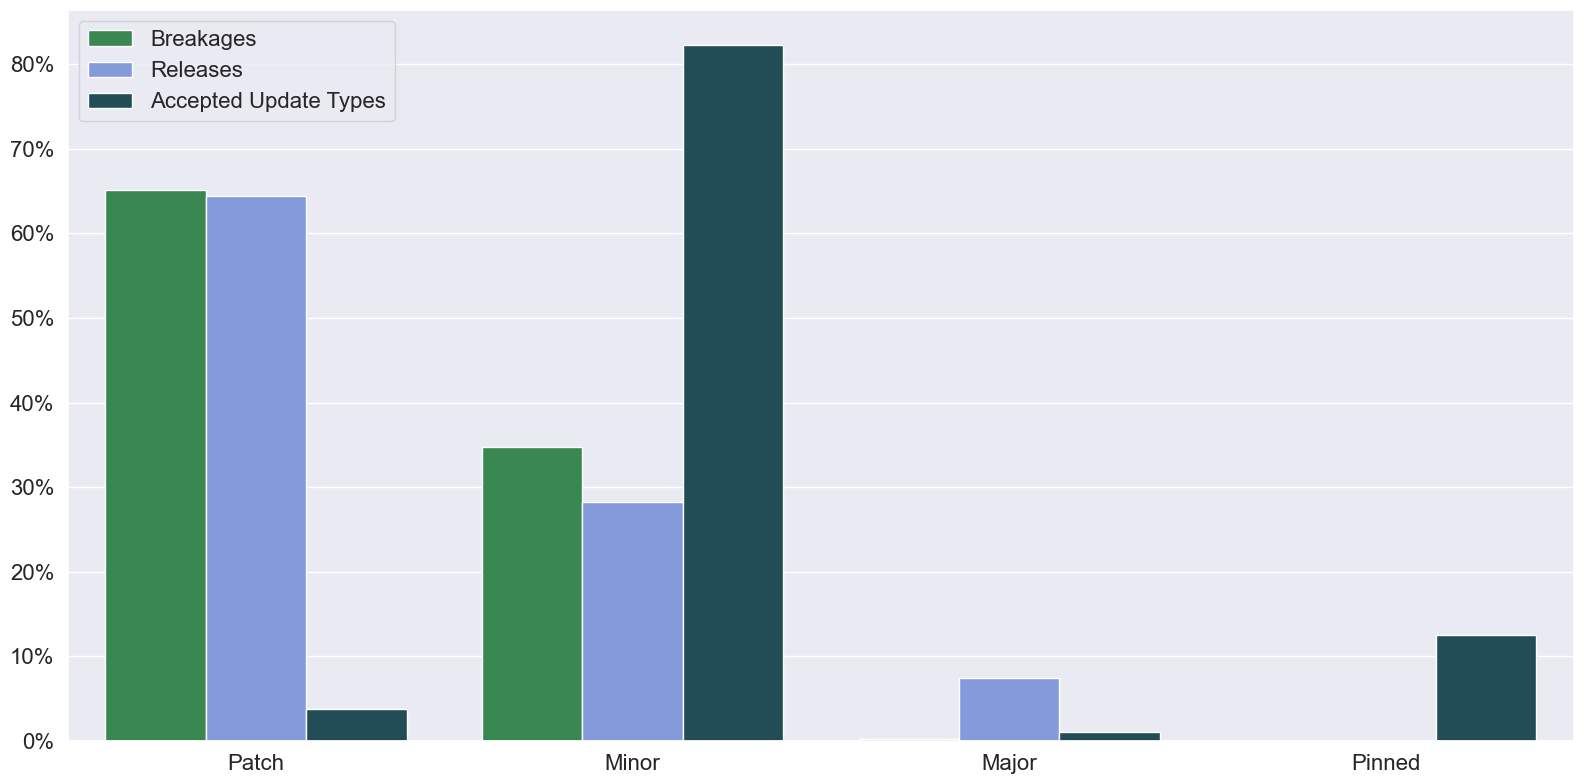

In [479]:
sns.set()
fig, ax = plt.subplots(figsize=(16, 8))

hue_order = [
    'Breakages',
    'Releases',
#     'Breakages/Releases',
    'Accepted Update Types'
]

params = dict(
    data=rq1_for_plot_aug[rq1_for_plot_aug['value_type'] != 'Breakages/Releases'],
    x="update_type",
    y='value',
    hue='value_type',
    order=['Patch', 'Minor', 'Major', 'Pinned'],
    hue_order=hue_order,
)
ax = sns.barplot(
    **params,
    palette=FOUR_COLOUR_PALETTE,
)

ax.set_title(f'', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('', fontsize=20)

y_labels = [f"{int(y*100)}%" for y in ax.get_yticks()]
ax.set_yticklabels(y_labels, fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)

# Make legend bigger
ax.legend(
    title="",
    fancybox=True,
    fontsize=16,
)
fig.tight_layout()
plt.show()
save_plot(fig, 'rq1.png')

## Frequency of Packages Releases

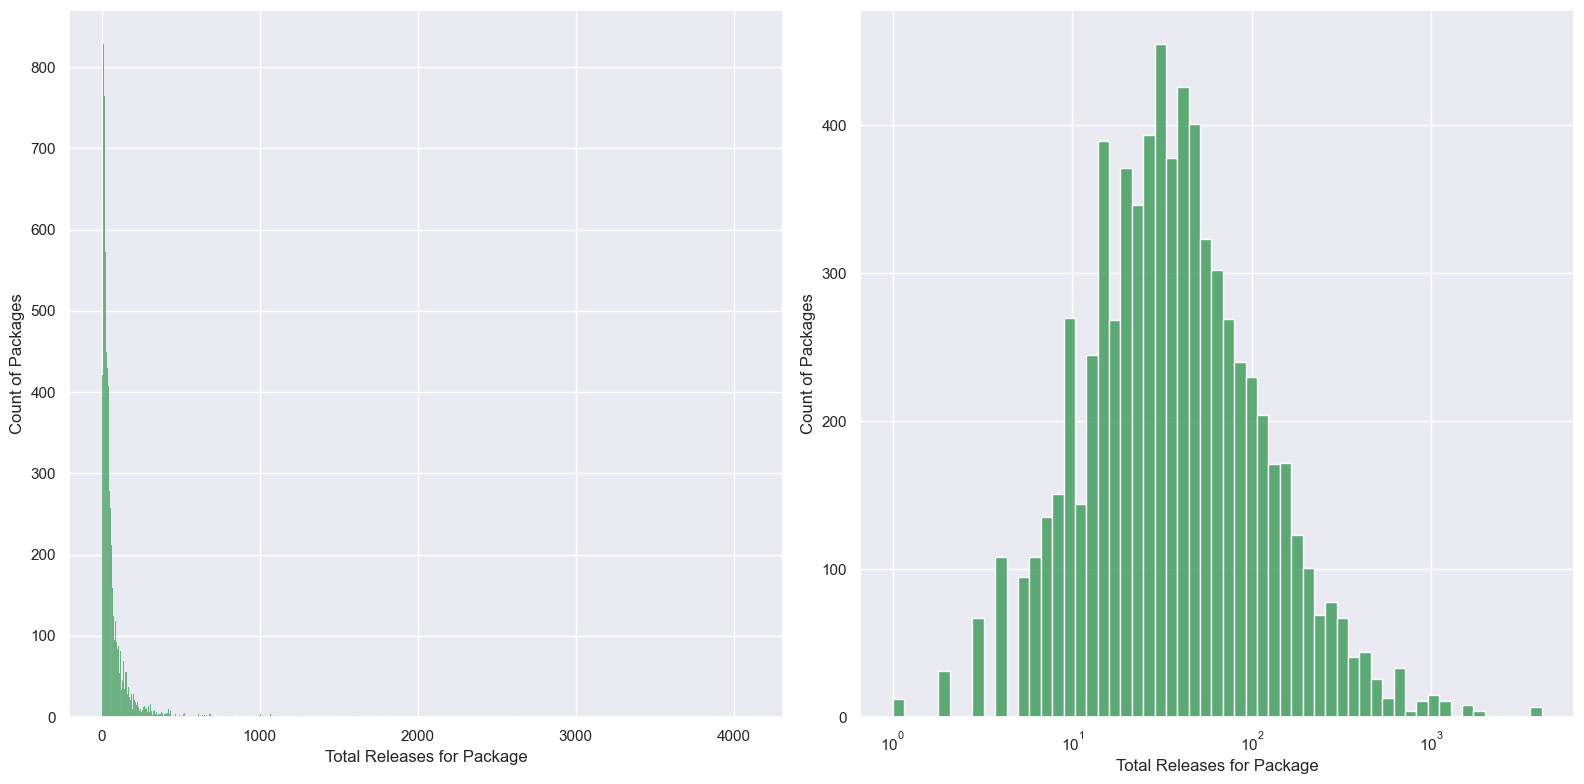

In [349]:
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

params = dict(
    data=library_releases['total_releases'],
    color=GK_GREEN,
)

sns.histplot(
    **params,
    ax=ax1,
    log_scale=(False, False),
)
ax1.set_xlabel('Total Releases for Package')
ax1.set_ylabel('Count of Packages')

g = sns.histplot(
    **params,
    ax=ax2,
    log_scale=(True, False),
)
ax2.set_xlabel('Total Releases for Package')
ax2.set_ylabel('Count of Packages')
fig.tight_layout()

### Number of Releases & Release Frequency vs Number of Breakages

In [354]:
def create_hist_plot(params, ax, cbar_ax=None, color=GK_GREEN):
    result = sns.histplot(
        **params,
        log_scale=(False, False),
        ax=ax,
        kde=True,
        bins=80,
        color=color,
        cbar=cbar_ax is not None,
        cbar_ax=cbar_ax
    )
    return result

def create_reg_line(params, ax):
    result = sns.regplot(
        **params,
        scatter=False,
        line_kws={"color": GK_PURPLE},
        ax=ax,
    )
    return result

total_releases_for_plot = library_releases[
    (library_releases['total_releases'] > 0) &
    (library_releases['broken_builds_caused'] > 0)
].copy()
total_releases_for_plot['log_total_releases'] = np.log10(total_releases_for_plot['total_releases'])
total_releases_for_plot['log_breaks'] = np.log10(total_releases_for_plot['broken_builds_caused'])


release_frequency_for_plot = library_releases.copy()
release_frequency_for_plot['freq'] = \
    release_frequency_for_plot['avg_time_between_releases'].astype('timedelta64[s]')
release_frequency_for_plot = release_frequency_for_plot.loc[
    (release_frequency_for_plot['total_releases'] >= 15) &
    (release_frequency_for_plot['freq'] > 0) &
    (release_frequency_for_plot['broken_builds_caused'] > 0)
].copy()

release_frequency_for_plot['log_freq'] = np.log10(release_frequency_for_plot['freq'])
release_frequency_for_plot['log_breaks'] = np.log10(release_frequency_for_plot['broken_builds_caused'])

In [352]:
release_frequency_for_plot['broken_builds_caused'].describe()
total_releases_for_plot['broken_builds_caused'].describe()

count    7360.000000
mean       15.821875
std       114.159336
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      5202.000000
Name: broken_builds_caused, dtype: float64

<ipython-input-353-228009031880>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_yticklabels([int(10 ** y) for y in ax_1.get_yticks()], size=16)
<ipython-input-353-228009031880>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels([int(10 ** x) for x in ax_1.get_xticks()], size=16)
<ipython-input-353-228009031880>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_yticklabels([int(10 ** y) for y in ax_2.get_yticks()], size=16)
<ipython-input-353-228009031880>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(xlabels, rotation=20, size=16)
<ipython-input-353-228009031880>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


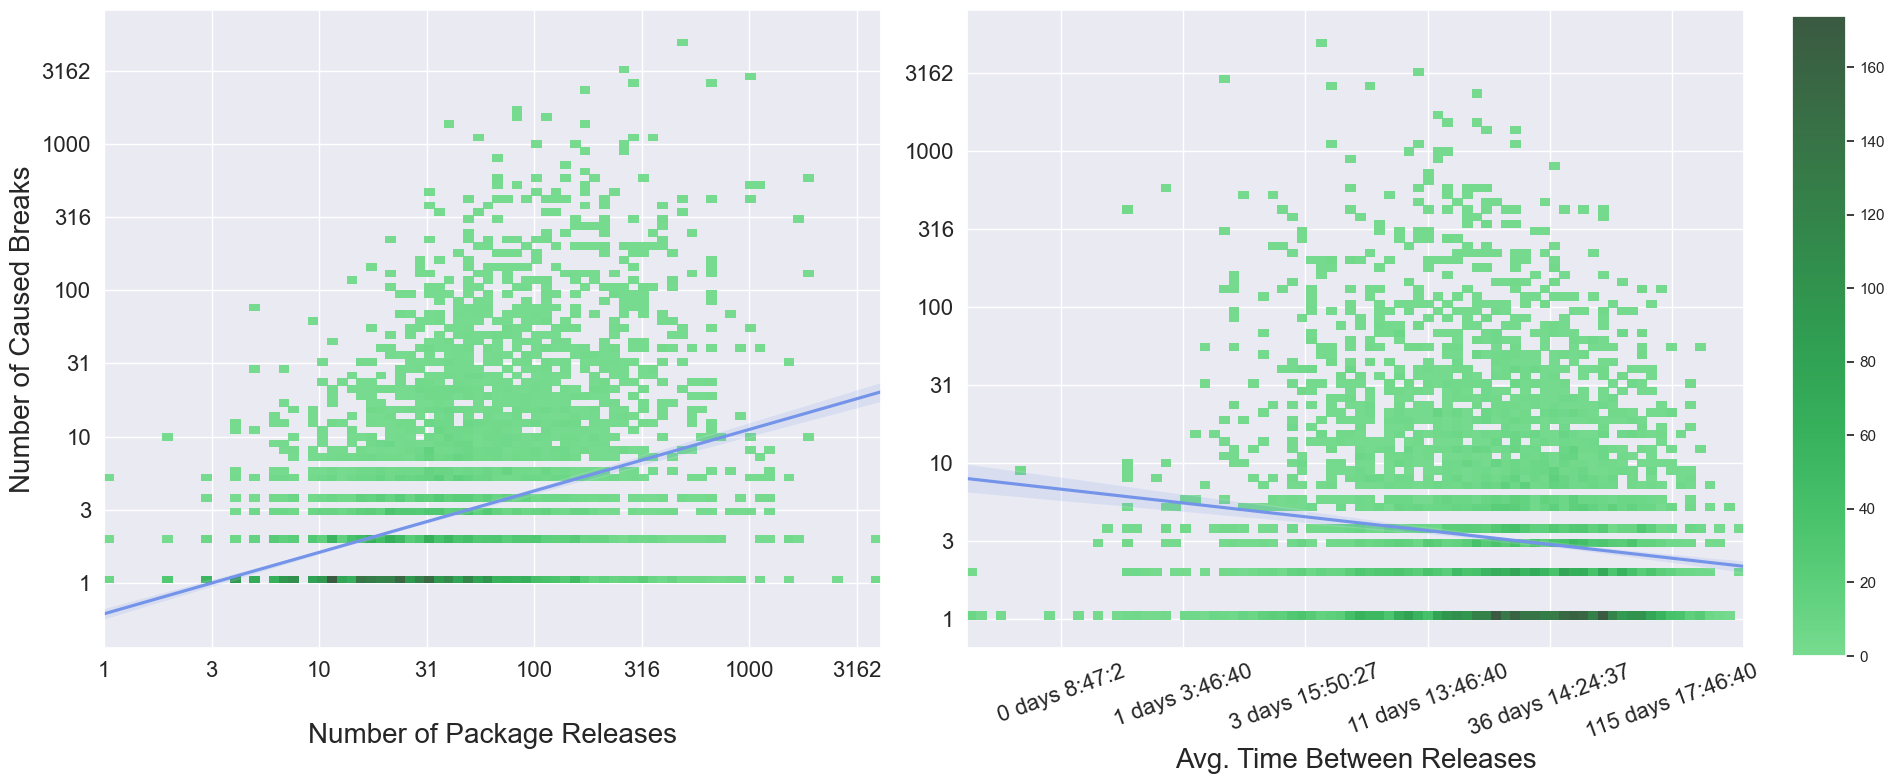

In [353]:
sns.set()
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
cbar_ax = fig.add_axes([1, 0.17, .03, 0.8])

params_1 = dict(
    data=total_releases_for_plot,
    x="log_total_releases",
    y="log_breaks",
)
ax_1 = create_hist_plot(params_1, ax_1, cbar_ax)
ax_1 = create_reg_line(params_1, ax_1)
ax_1.set_title(f'', fontsize=20)
ax_1.set_xlabel(f'Number of Package Releases', fontsize=20, labelpad=30)
ax_1.set_ylabel('Number of Caused Breaks', fontsize=20)
ax_1.set_yticklabels([int(10 ** y) for y in ax_1.get_yticks()], size=16)
ax_1.set_xticklabels([int(10 ** x) for x in ax_1.get_xticks()], size=16)
ax_1.set_ylim()

params_2 = dict(
    data=release_frequency_for_plot,
    x="log_freq",
    y="log_breaks",
)
ax_2 = create_hist_plot(params_2, ax_2)
ax_2 = create_reg_line(params_2, ax_2)
ax_2.set_title(f'', fontsize=20)
ax_2.set_xlabel(f'Avg. Time Between Releases', fontsize=20)
ax_2.set_ylabel('', fontsize=20)
ax_2.set_yticklabels([int(10 ** y) for y in ax_2.get_yticks()], size=16)
x_seconds = [10 ** x for x in ax_2.get_xticks()]
xlabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(x_seconds, unit='s')]
ax_2.set_xticklabels(xlabels, rotation=20, size=16)
ax_2.set_ylim()


fig.tight_layout()
plt.show()
save_plot(fig, 'breakages_to_package_releases_and_frequency.png')

### Release Frequency vs Number of Breakages

## How often is Greenkeeper opening issues?

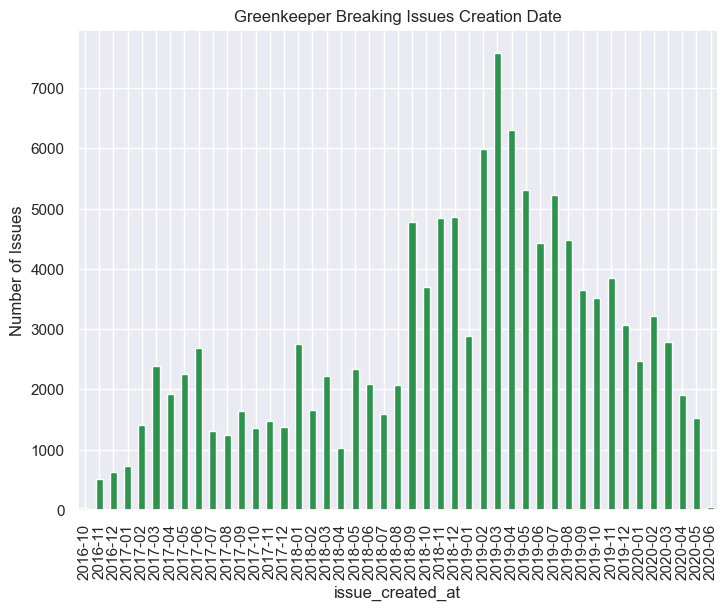

In [356]:
issues_grouped = issues.groupby(issues["issue_created_at"].dt.to_period('M'))
issues_grouped['issue_created_at'].count()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Number of Issues')
ax.set_xlabel('Created At')
ax.set_title('Greenkeeper Breaking Issues Creation Date')
issue_creation_date = \
    issues_grouped['issue_created_at']\
        .count()\
        .plot(
            kind="bar",
            color=GK_GREEN
        )
plt.show()

## Closing Issues & Response Times

### How often are Greenkeeper Build Breakage Issue Reports closed?

In [357]:
n_issues = len(issues)
closed_issues = issues[issues.issue_state == "closed"]
percent_closed = calculate_percent(len(closed_issues), n_issues)
print(f"{percent_closed}% ({len(closed_issues)}) of Greenkeeper issues are eventually closed")

79.82% (98341) of Greenkeeper issues are eventually closed


### How much time do Greenkeeper issues take to be closed?

In [358]:
time_to_close_issue = pd.DataFrame({
    'issue_id': closed_issues.issue_id, 
    'time_to_close_issue': closed_issues.apply(lambda row: row.issue_closed_at - row.issue_created_at, axis=1),
})

median_time = time_to_close_issue['time_to_close_issue'].median()
print(f"The median time to close the issue is {median_time} hours")

The median time to close the issue is 4 days 11:04:25 hours


In [359]:
print("Five number summary for the time to close the Greenkeeper issue:")
print(time_to_close_issue['time_to_close_issue'].describe())

Five number summary for the time to close the Greenkeeper issue:
count                         98341
mean     43 days 04:48:28.851343748
std      98 days 22:44:48.052636698
min                 0 days 00:00:04
25%                 0 days 09:58:19
50%                 4 days 11:04:25
75%                35 days 07:48:16
max              1219 days 02:01:10
Name: time_to_close_issue, dtype: object


<ipython-input-360-1ff3114b039f>:16: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  bp = ax.boxplot(
<ipython-input-360-1ff3114b039f>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


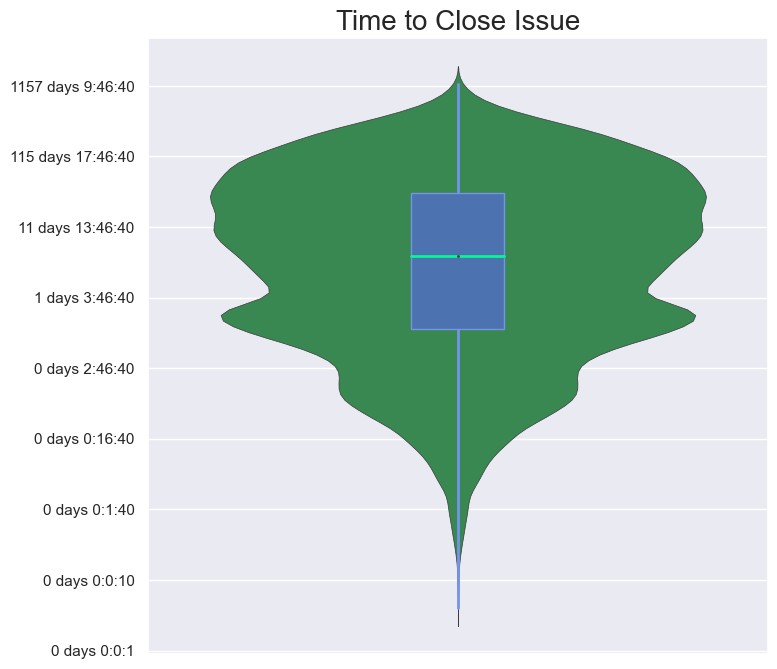

In [360]:
fig, ax = plt.subplots(figsize=(8, 8))

time_to_close_issue['val'] = np.log10(time_to_close_issue['time_to_close_issue'].astype('timedelta64[s]'))

params = dict(
    data=time_to_close_issue,
    y='val',
)

g = sns.violinplot(
    **params,
    color=GK_GREEN,
    linewidth=0.5,
)

bp = ax.boxplot(
    data=time_to_close_issue,
    x='val',
    patch_artist=True,
    positions=np.array([0]),
    showcaps=False,
    whis='range',
    boxprops=dict(
        alpha=1,
        color=GK_PURPLE,
    ),
    whiskerprops=dict(
        color=GK_PURPLE,
        linewidth=2,
    ),
    medianprops=dict(
        color=GK_GREEN_LIGHT,
        linewidth=2,
    )
)

ax.set_title(f'Time to Close Issue', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('', fontsize=20)

y_seconds = [10 ** y for y in g.get_yticks()[:-1]]
ylabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(y_seconds, unit='s')]
g.set_yticklabels(ylabels)
g.set_xticklabels(labels=[])
plt.show()
fig.tight_layout()
save_plot(fig, 'time_to_close_issue.png')

## Comments on Breaking Issues

### How many comments do Greenkeeper Breaking Issues have?

In [361]:
print("Five number summary for the number of comments on Greenkeeper Breakage issues:")
print(issues["issue_num_comments"].describe())

Five number summary for the number of comments on Greenkeeper Breakage issues:
count    123197.000000
mean          4.775555
std          29.850343
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2500.000000
Name: issue_num_comments, dtype: float64


In [362]:
threshold = 2
at_least_one_comment = issues[issues["issue_num_comments"] >= threshold]
percent_one_comment = calculate_percent(len(at_least_one_comment), len(issues))
print(f"{percent_one_comment}% ({len(at_least_one_comment)}) of issues have at least {threshold} comment.")


47.95% (59067) of issues have at least 2 comment.


### How many of these are from Greenkeeper?

In [363]:
comments_by_greenkeeper = comments[
    (comments['comment_user_type'] == "Bot") & 
    (comments['comment_user_login'].str.contains("greenkeeper"))
]
percent_comments_by_greenkeeper = calculate_percent(len(comments_by_greenkeeper), len(comments))
print(f"{percent_comments_by_greenkeeper}% ({len(comments_by_greenkeeper)}) of comments on breaking issue reports opened by Greenkeeper are from the Greenkeeper bot.")

96.89% (354250) of comments on breaking issue reports opened by Greenkeeper are from the Greenkeeper bot.


### User Comments

In [364]:
users_comments = comments[(comments['comment_user_type'] == "User")].copy()
percent_of_user_comments = calculate_percent(len(users_comments), len(comments))
unique_issue_ids = users_comments['comment_issue_id'].unique()
percent_of_issues_with_user_comment = calculate_percent(len(unique_issue_ids), len(issues['issue_id']))
print(f"{len(users_comments)} comments from users ({percent_of_user_comments}% of comments) on {len(unique_issue_ids)} unique issues ({percent_of_issues_with_user_comment}% of issues)")

10724 comments from users (2.93% of comments) on 9854 unique issues (8.0% of issues)


### What are users saying?

In [376]:
NOT_CLASSIFIED = 'Other'

# Set all comments to 'Not Classified'
users_comments['comment_classification'] = NOT_CLASSIFIED
users_comments = users_comments.drop(users_comments[pd.isna(users_comments['comment_body'])].index)

#### How many link a fix?

In [377]:
FIX_REFERENCED = 'Fix Referenced'

reg_pr_url = 'https:\/\/github\.com\/[\S]*\/(pull|issues)\/[\S]*'
reg_closed_by = '(closed|fixed|resolved|done|updated) (in|by|via|with)'
reg_number = '^#\d*|(Merged|Close|PR|see).*#\d*'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_pr_url, case=True, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_closed_by, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_number, case=False, regex=True))
    ),
    'comment_classification'
] = FIX_REFERENCED

fix_referenced_comments = users_comments[users_comments['comment_classification'] == FIX_REFERENCED]
print(f"{len(fix_referenced_comments)} comments from users explicitly link a fix.")
# fix_referenced_comments['comment_body'].sample(10)

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


3704 comments from users explicitly link a fix.


#### How many appear to be a false positive?

In [378]:
FALSE_ALARM = 'False Alarm'

reg_flaky = 'flake|flaky|flakiness|fluke|(server|test) hiccup|inconsistent test|brittle test|unstable unit test|unstable test|Spurious test failure|Tests are passing'
reg_random = '(fail|failing) random|random.*fail.*|random build error|intermittent'
reg_retrigger = '(retrigger|re-trigger|rebuild|re-build|restart|re-starting|re-run|retried|rerun|reran|re-ran)'
reg_false_positive = 'false (positive|alarm|negative|alert)|falso positive'
reg_invalid = '^(invalid|not applicable|not (a|an) issue|unrelated)|Couldn\'t reproduce|all tests pass'
reg_unrelated='(unrelated.*fail)|(failed for other reasons)|(build is actually passing)|build hiccup'
reg_timeout = 'timeout|time-out'


users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_flaky, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_random, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_retrigger, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_false_positive, case=False, regex=True)) | 
        (users_comments['comment_body'].str.contains(pat=reg_invalid, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_unrelated, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_timeout, case=False, regex=True))
    ),
    'comment_classification'
] = FALSE_ALARM


false_alarm_comments = users_comments[users_comments['comment_classification'] == FALSE_ALARM]
print(f"{len(false_alarm_comments)} comments from users indicate a false alarm.")
# false_alarm_comments['comment_body'].sample(10)

1959 comments from users indicate a false alarm.


#### Transient Failure

In [379]:
TRANSIENT_FAILURE = 'Transient Failure'

reg_transient = 'transient.*fail'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_transient, case=False, regex=True))
    ),
    'comment_classification'
] = TRANSIENT_FAILURE

transient_failure_comments = users_comments[users_comments['comment_classification'] == TRANSIENT_FAILURE]
print(f"{len(transient_failure_comments)} comments saying failure was caused by transient dependency")
# transient_failure_comments['comment_body'].sample(10)

26 comments saying failure was caused by transient dependency


#### Mention Greenkeeper

In [380]:
MENTION_GREENKEEPER = 'Mention Greenkeeper'

reg_greenkeeper = '(greenkeeper)'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_greenkeeper, case=False, regex=True))
    ),
    'comment_classification'
] = MENTION_GREENKEEPER

mention_greenkeeper_comments = users_comments[users_comments['comment_classification'] == MENTION_GREENKEEPER]
print(f"{len(mention_greenkeeper_comments)} comments mentioning Greenkeeper")
# mention_greenkeeper_comments['comment_body'].sample(10)

386 comments mentioning Greenkeeper


#### Mention Travis or another build system

In [381]:
MENTION_CI_SYSTEM = 'Mention CI System'

reg_ci_system = '(travis|CircleCI|circle ci|jarvis|jenkins|CI.*issue)'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_ci_system, case=False, regex=True))
    ),
    'comment_classification'
] = MENTION_CI_SYSTEM

mention_ci_system_comments = users_comments[users_comments['comment_classification'] == MENTION_CI_SYSTEM]
print(f"{len(mention_ci_system_comments)} comments the projects CI build system")
# mention_greenkeeper_comments['comment_body'].sample(10)

490 comments the projects CI build system


#### How many say the issue is resolved (no link to fix)

In [382]:
FIX_MENTIONED = 'Fix Mentioned'

reg_fixed = '(fix(ed)*|resolved|done|solved|closed|updated|upgraded|closing|merged)|(fix|fixed|bumped|merged|upgraded).*manually|manually.*merged'
reg_update_in = '.*update.*in.*|Making a PR'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_fixed, case=False, regex=True)) | 
        (users_comments['comment_body'].str.contains(pat=reg_update_in, case=False, regex=True))
    ),
    'comment_classification'
] = FIX_MENTIONED

fix_mentioned_comments = users_comments[users_comments['comment_classification'] == FIX_MENTIONED]
print(f"{len(fix_mentioned_comments)} comments from users saying the issues has been fixed (without linking the fix).")
# fix_mentioned_comments['comment_body'].sample(10)

1865 comments from users saying the issues has been fixed (without linking the fix).


#### Breakdown of User Comments

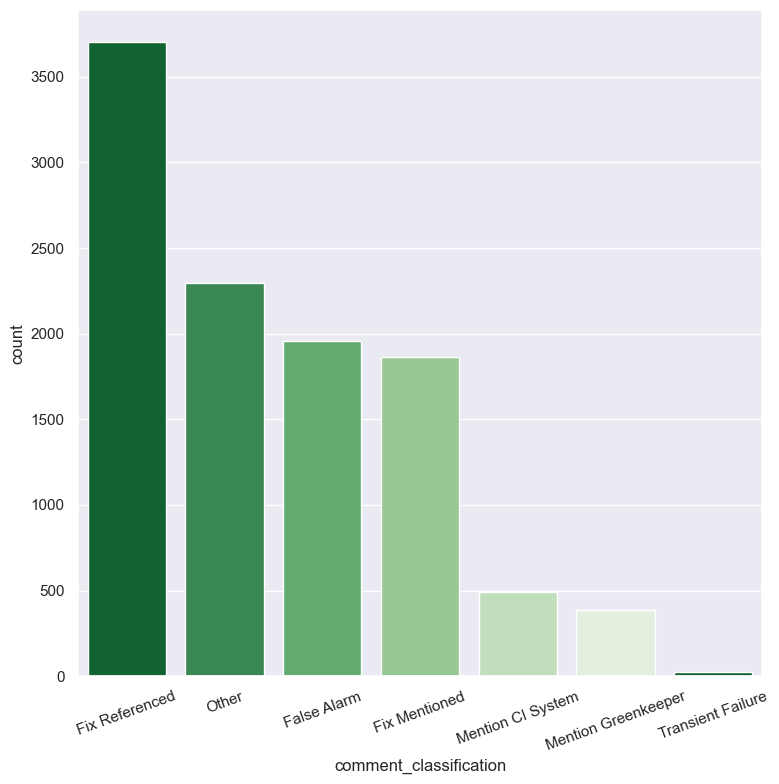

In [383]:
sns.set()

fig, ax = plt.subplots(figsize=(8, 8))

users_comments['comment_classification'].unique()

cp = sns.countplot(
    data=users_comments,
    x="comment_classification",
    order = users_comments['comment_classification'].value_counts().index,
    palette=COLOUR_PALETTE,
)

# gist_earth
# Paired
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
fig.tight_layout()
save_plot(cp.get_figure(), 'types_of_user_comments.png')

### How Quickly Do Users Comment

In [384]:
first_user_comments = \
    users_comments.loc[users_comments.groupby(['comment_issue_id'])["comment_created_at"].idxmin()]
rel_time_comment_to_issue = pd.DataFrame({
    'comment_id': first_user_comments['comment_id'],
    'comment_created_at': first_user_comments['comment_created_at'],
    'issue_id': first_user_comments['comment_issue_id'],
})
# rel_time_comment_to_issue['comment_created_at']
rel_time_comment_to_issue.reset_index()

def get_comment_created_at(row, issues):
    issue = issues[issues['issue_id'] == row.issue_id]
    if issue.empty:
        return pd.NA
    return issue['issue_created_at'].iloc[0]
    
    
rel_time_comment_to_issue['issue_created_at'] = \
    rel_time_comment_to_issue.apply(lambda row: get_comment_created_at(row, issues), axis=1)
rel_time_comment_to_issue = rel_time_comment_to_issue.dropna()
rel_time_comment_to_issue['issue_created_at'] = pd.to_datetime(rel_time_comment_to_issue['issue_created_at'], utc=True)

def get_time_diff(row):
    return row['comment_created_at'] - row['issue_created_at']

rel_time_comment_to_issue['time_diff'] = rel_time_comment_to_issue.apply(get_time_diff, axis=1)
rel_time_comment_to_issue['time_diff'].describe()


count                          9830
mean     26 days 06:01:46.397761955
std      65 days 16:10:10.331253024
min                 0 days 00:00:00
25%          0 days 07:45:44.500000
50%                 2 days 12:22:44
75%         18 days 22:36:09.750000
max              1039 days 05:34:55
Name: time_diff, dtype: object

In [385]:
def get_comment_type(row):
    if row['comment_id'] in fix_referenced_comments['comment_id'].unique():
        return FIX_REFERENCED
    if row['comment_id'] in false_alarm_comments['comment_id'].unique():
        return FALSE_ALARM
    if row['comment_id'] in transient_failure_comments['comment_id'].unique():
        return TRANSIENT_FAILURE
    if row['comment_id'] in mention_greenkeeper_comments['comment_id'].unique():
        return MENTION_GREENKEEPER
    if row['comment_id'] in mention_ci_system_comments['comment_id'].unique():
        return MENTION_CI_SYSTEM
    if row['comment_id'] in fix_mentioned_comments['comment_id'].unique():
        return FIX_MENTIONED
    return NOT_CLASSIFIED

rel_time_comment_to_issue['comment_classification'] = rel_time_comment_to_issue.apply(get_comment_type, axis=1)
rel_time_comment_to_issue['x_log'] = \
    np.log10(rel_time_comment_to_issue['time_diff'].astype('timedelta64[s]'))

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<ipython-input-388-fede857db1b6>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(type_labels, fontsize=14, rotation=0)
<ipython-input-388-fede857db1b6>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(seconds_labels, fontsize=14, rotation=30)


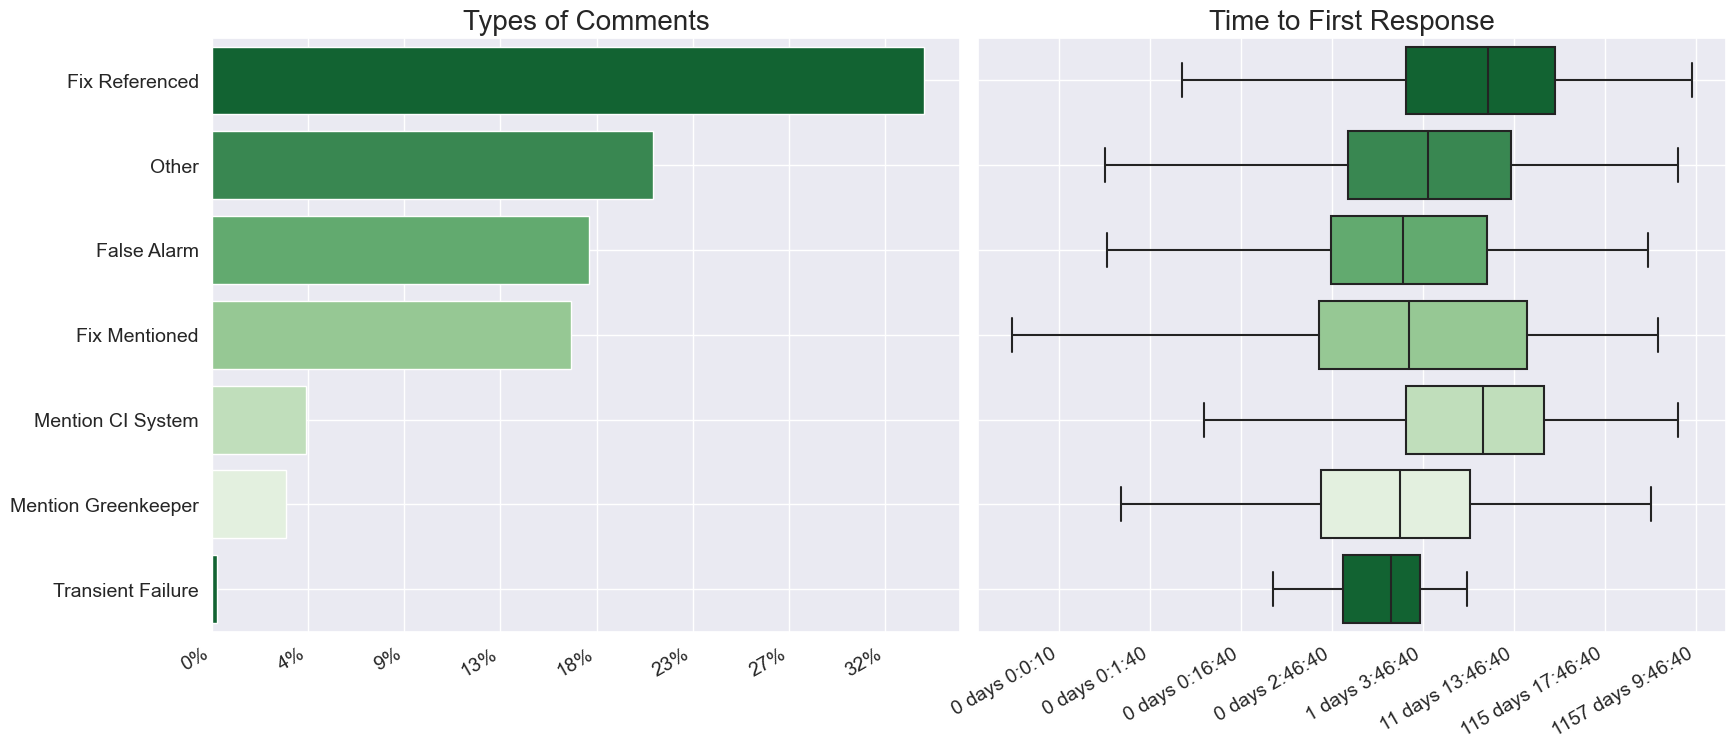

In [388]:
sns.set()
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

params_1 = dict(
    data=users_comments,
    y="comment_classification",
    order = users_comments['comment_classification'].value_counts().index,
)
ax_1 = sns.countplot(
    **params_1,
    palette=COLOUR_PALETTE,
    ax=ax_1,
)
ax_1.set_title(f'Types of Comments', fontsize=20)
type_labels = [f'{int((y/len(users_comments)*100))}%' for y in ax_1.get_xticks()]
ax_1.set_xticklabels(type_labels, fontsize=14, rotation=0)
ax_1.set_yticklabels(ax_1.get_yticklabels(), rotation=0, fontsize=14)
ax_1.set_ylabel('', fontsize=20)
ax_1.set_xlabel('', fontsize=20)
ax_1.grid(b=True, which='major', color='w', linewidth=1.0)


params_2 = dict(
    data=rel_time_comment_to_issue,
    x='x_log',
    y='comment_classification'
)
ax_2 = sns.boxplot(
    **params_2,
    showfliers=False,
    palette=COLOUR_PALETTE,
)
seconds = [10 ** x for x in ax_2.get_xticks()]
seconds_labels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(seconds, unit='s')]
ax_2.set_xticklabels(seconds_labels, fontsize=14, rotation=30)
# ax_2.set_yticklabels(ax_2.get_yticklabels(), rotation=0, fontsize=14)
ax_2.set_yticklabels([])
ax_2.set_title(f'Time to First Response', fontsize=20)
ax_2.set_ylabel('', fontsize=20)
ax_2.grid(b=True, which='major', color='w', linewidth=1.0)

ax_2.set_xlabel('', fontsize=20)
fig.tight_layout()
fig.autofmt_xdate()
plt.show()
save_plot(fig, 'types_of_comments_and_time_until_comment_type.png')

## How successful is pinning the dependency?

In [480]:
## This could take a few minutes
def get_first_comment(issue):
    issue_comments = get_comments_for_issue(issue['issue_id'])
    if issue_comments.empty:
        return None
    first_comment = issue_comments[issue_comments['comment_id'] == issue_comments['comment_id'].min()]
    first_comment
    return first_comment['comment_id'].values[0].astype(np.int64)

issue_first_comment = pd.DataFrame({
    'issue_id': issues.issue_id, 
    'comment_id': issues.apply(lambda row: get_first_comment(row), axis=1),
})
issue_first_comment_filtered = issue_first_comment[pd.notna(issue_first_comment['comment_id'])].copy()

In [481]:
## This might take a few minutes
pin_fail_string = "your tests are still failing"
pin_success_string = "your tests are passing again"

def comment_body_contains_string(issue_first_comment, string):
    if pd.isna(issue_first_comment['comment_id']):
        return False
    comment = comments[comments['comment_id'] == issue_first_comment['comment_id']]
    return comment['comment_body'].str.contains(string, na=False).values[0]


issue_first_comment_filtered['successful_pin'] = \
    issue_first_comment_filtered.apply(lambda row: comment_body_contains_string(row, pin_success_string), axis=1)

issue_first_comment_filtered['failed_pin'] = \
    issue_first_comment_filtered.apply(lambda row: comment_body_contains_string(row, pin_fail_string), axis=1)

In [482]:
no_pin_attempts = issue_first_comment_filtered[
    (issue_first_comment_filtered['successful_pin'] == False) & 
    (issue_first_comment_filtered['failed_pin'] == False)
]

pin_attempts = issue_first_comment_filtered[
    (issue_first_comment_filtered['successful_pin'] == True) | 
    (issue_first_comment_filtered['failed_pin'] == True)
]
succ_pin_count = len(pin_attempts[pin_attempts['successful_pin'] == True])
failed_pin_count = len(pin_attempts[pin_attempts['failed_pin'] == True])
total_pin_count = len(pin_attempts)
no_pin_attempt_count = len(issues) - len(pin_attempts)# len(no_pin_attempts)
percent_pin_attempted = calculate_percent(total_pin_count, len(issues))
percent_succ_pin_count = calculate_percent(succ_pin_count, total_pin_count)
percent_failed_pin_count = calculate_percent(failed_pin_count, total_pin_count)

print(f"{percent_pin_attempted}% ({total_pin_count}) of issues were attempted to be resolved by automatically pinning the dependency.")
print(f"Of those, {percent_succ_pin_count}% ({succ_pin_count}) were successful, and {percent_failed_pin_count}% ({failed_pin_count}) were not successful.")

71.86% (88525) of issues were attempted to be resolved by automatically pinning the dependency.
Of those, 33.07% (29277) were successful, and 66.93% (59248) were not successful.


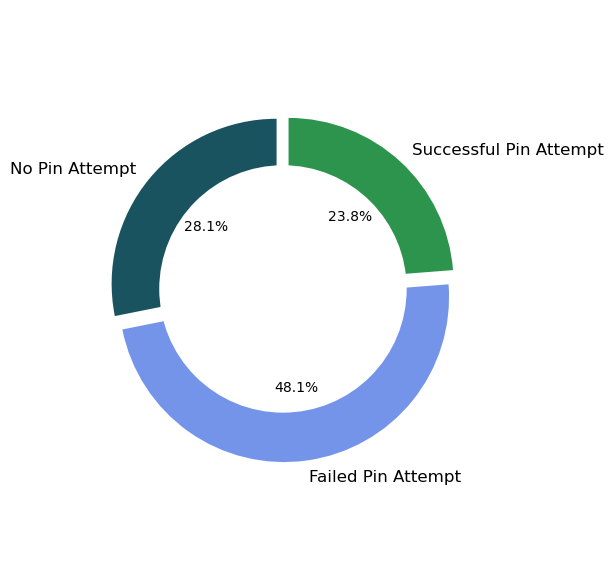

In [509]:
mpl.style.use("default")
labels = "No Pin Attempt", 'Failed Pin Attempt', 'Successful Pin Attempt'
sizes = [no_pin_attempt_count, failed_pin_count, succ_pin_count]
colors = [THREE_COLOUR_PALETTE[2], THREE_COLOUR_PALETTE[1], THREE_COLOUR_PALETTE[0]]
fig, ax1 = plt.subplots(figsize=(6, 6))
explode = (0.05,0.05,0.05)
patches, texts, autotexts = ax1.pie(
    sizes,
    colors=colors,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.55,
    explode=explode,
)
texts[0].set_fontsize(12)
texts[1].set_fontsize(12)
texts[2].set_fontsize(12)

centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

save_plot(fig, 'pin_attempts.png')

### How often do users take the Pin approach?

In [491]:
# PPA = Pin Passing Again
# Get issue IDs that have a successful pin
ppa_ids = pin_attempts[pin_attempts['successful_pin'] == True]['issue_id']
issues_with_ppa = issues[issues['issue_id'].isin(ppa_ids)]

# Get comments and events for issues with successful pin.
issue_ids_with_ppa = issues_with_ppa['issue_id']
comments_for_issues_with_ppa = \
    comments[comments['comment_issue_id'].isin(issue_ids_with_ppa)]
events_for_issues_with_ppa = \
    events[events['event_issue_id'].isin(issue_ids_with_ppa)]

# It doesn't look like there is any indication on the issue report that the user took the bots 
# advice and pinned the dependency using the bots link.
# See issue_id=614163469 comment_id=625987320
# user_comments_for_issues_with_ppa = \
#     comments_for_issues_with_ppa[comments_for_issues_with_ppa['comment_user_type'] == 'User']
# user_comments_for_issues_with_successful_pin.head(20)
# get_comments_for_issue(614163469)

In [492]:
ppa_issues_commit_events = \
    events_for_issues_with_ppa[pd.notna(events_for_issues_with_ppa.event_commit_id)]
ppa_commit_shas = ppa_issues_commit_events['event_commit_id']
ppa_commits = commits[commits['commit_sha'].isin(ppa_commit_shas)]
grouped_by_event_id = ppa_commits.groupby(by=['commit_event_id'])
changed_files_on_pin = ['package.json', 'package-lock.json', 'yarn.lock']
pinned_idxs = list()
for name, group in grouped_by_event_id:
    other_files = group[~group['commit_file_name'].isin(changed_files_on_pin)]
    if other_files.empty:
        pinned_idxs.extend(group.index)
        

In [493]:
succ_pinn_commits = ppa_commits.loc[pinned_idxs]\
    .loc[ppa_commits['commit_file_changes'] == 2]\
    .sort_values(by=['commit_file_changes'])
# succ_pinn_commits 
succ_pinn_commits[['commit_file_name', 'commit_file_additions', 'commit_file_deletions', 'commit_file_changes']]

,commit_file_name,commit_file_additions,commit_file_deletions,commit_file_changes
17621,package.json,1,1,2
3263,package.json,1,1,2
3159,package.json,1,1,2
3161,package.json,1,1,2
3275,package.json,1,1,2
...,...,...,...,...
6718,package.json,1,1,2
6638,package.json,1,1,2
6668,package.json,1,1,2
7550,package.json,1,1,2


## Type Of Changes Made By Clients

In [389]:
total_commit_count = len(commits['commit_sha'].unique())

ds = {
    'file_name': list(),
    'value': list(),
    'is_addition': list(),
}

seen_commits = dict()
seen_files = dict()
for i, row in commits.iterrows():
    if row['commit_sha'] not in seen_commits:
        seen_commits[row['commit_sha']] = row['commit_event_id']
    if row['commit_event_id'] != seen_commits[row['commit_sha']]:
        continue
    if row['commit_file_name'] not in seen_files:  
        seen_files[row['commit_file_name']] = 0
    seen_files[row['commit_file_name']] += 1
    if row['commit_file_additions'] > 0:
        ds['file_name'].append(row['commit_file_name'])
        ds['value'].append(row['commit_file_additions'])
        ds['is_addition'].append(True)
    
    if row['commit_file_deletions'] > 0:
        ds['file_name'].append(row['commit_file_name'])
        ds['value'].append(row['commit_file_deletions'])
        ds['is_addition'].append(False)
df2 = pd.DataFrame(ds)
seen_files_df = pd.DataFrame({
    'file_name': seen_files.keys(),
    'count': seen_files.values()
})
seen_files_df['ratio'] = seen_files_df['count'] / total_commit_count

<ipython-input-390-74472996a58e>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(x_labels, fontsize=14)
<ipython-input-390-74472996a58e>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels([int(x) for x in ax_2.get_xticks()], fontsize=14)


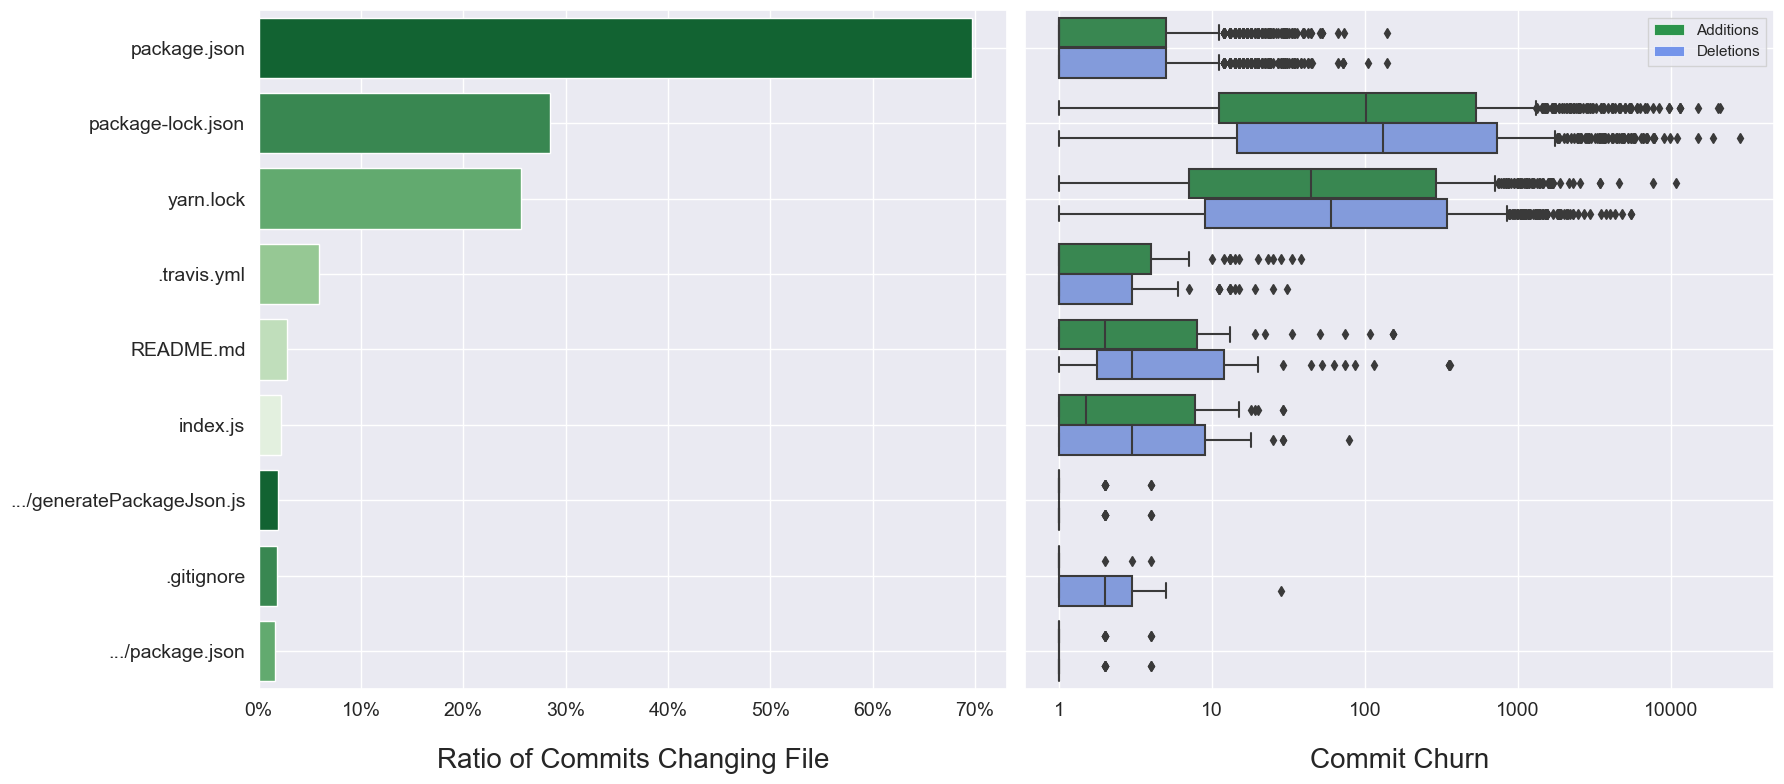

In [390]:
for_plot_ratio = seen_files_df.sort_values(by=['ratio'], ascending=False).head(9)

popular_files = seen_files_df.sort_values(by=['ratio'], ascending=False).head(9)['file_name']
for_plot = df2[df2['file_name'].isin(popular_files)].copy()

def format_file_name(file_name):
    file_name_str = file_name.get_text()
    if '/' not in file_name_str:
        return file_name_str
#     result = f'{file_name_str[:file_name_str.find("/")]}/.../{file_name_str[file_name_str.rfind("/") + 1:]}'
    result = f'.../{file_name_str[file_name_str.rfind("/") + 1:]}'
    return result

sns.set()
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

params_1 = dict(
    data=for_plot_ratio,
    x='ratio',
    y='file_name',
)
ax_1 = sns.barplot(
    **params_1,
    palette=COLOUR_PALETTE,
    ax=ax_1,
)
ax_1.set_title(f'', fontsize=20)
ax_1.set_ylabel('', fontsize=20)
ax_1.set_xlabel('Ratio of Commits Changing File', fontsize=20, labelpad=20)
y_labels = [format_file_name(y) for y in ax_1.get_yticklabels()]
ax_1.set_yticklabels(y_labels, fontsize=14)
x_labels = [f"{int(x*100)}%" for x in ax_1.get_xticks()]
ax_1.set_xticklabels(x_labels, fontsize=14)
ax_1.grid(b=True, which='major', color='w', linewidth=1.0)


params_2 = dict(
    data=for_plot,
    x='value',
    y='file_name',
    hue="is_addition",
    order=popular_files
)
ax_2 = sns.boxplot(
    **params_2,
    palette=TWO_COLOUR_PALETTE,
    ax=ax_2
)
ax_2.set_xscale("log")
ax_2.set_title(f'', fontsize=20)
ax_2.set_ylabel('', fontsize=20)
ax_2.set_xlabel('Commit Churn', fontsize=20, labelpad=20)
ax_2.set_xticklabels([int(x) for x in ax_2.get_xticks()], fontsize=14)
# y_labels = [format_file_name(y) for y in ax_2.get_yticklabels()]
# ax_2.set_yticklabels(y_labels, fontsize=10)
ax_2.set_yticklabels([], fontsize=14)
ax_2.grid(b=True, which='major', color='w', linewidth=1.0)
leg_addition = mpatches.Patch(facecolor=TWO_COLOUR_PALETTE[0], label='Additions', linewidth = 0.5)
leg_deletions = mpatches.Patch(facecolor=TWO_COLOUR_PALETTE[1], label = 'Deletions', linewidth = 0.5)
ax_2.legend(
    handles=[leg_addition, leg_deletions],
    title="",
    fancybox=False
)


fig.tight_layout()
plt.show()
save_plot(fig, 'changed_files_ratio_and_commit_churn.png')

### Are these methods of specifying accepted update types effective?

## Do lots of client's breaking builds trigger a response from the provider?

In [7]:
library_versions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556742 entries, 0 to 556741
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   package_name          556742 non-null  object
 1   version               556742 non-null  object
 2   version_published_at  556742 non-null  object
 3   version_release_type  376927 non-null  object
dtypes: object(4)
memory usage: 17.0+ MB


In [8]:
library_releases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7361 entries, 0 to 7360
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   package_name                       7361 non-null   object         
 1   total_time_diff                    7361 non-null   object         
 2   avg_time_between_releases          7361 non-null   timedelta64[ns]
 3   first_release_date                 7361 non-null   datetime64[ns] 
 4   last_release_date                  7361 non-null   datetime64[ns] 
 5   total_releases                     7361 non-null   int64          
 6   broken_builds_caused               7361 non-null   int64          
 7   avg_time_between_releases_seconds  7361 non-null   int64          
dtypes: datetime64[ns](2), int64(3), object(2), timedelta64[ns](1)
memory usage: 460.2+ KB


In [9]:
columns = [
    'issue_id',
    'issue_created_at',
    'issue_updated_at',
    'issue_closed_at',
    'issue_dependency_name',
    'issue_dependency_type',
    'issue_dependency_actual_version',
    'issue_dependency_next_version',
]
issues_trigger = issues.loc[
    ~pd.isna(issues['issue_dependency_name']),
    columns
].copy()
issues_trigger['issue_created_at_day'] = issues_trigger['issue_created_at'].dt.floor('D')

In [10]:
columns = [
    'issue_dependency_name',
    'issue_dependency_actual_version',
    'issue_dependency_next_version',
    'issue_created_at_day'
]
common_breaking_issues = issues_trigger.groupby(by=columns)['issue_id']\
    .count()\
    .reset_index(name='count')\
    .sort_values(['count'], ascending=False)
# common_breaking_issues = common_breaking_issues[common_breaking_issues['count'] > 10]
common_breaking_issues

,issue_dependency_name,issue_dependency_actual_version,issue_dependency_next_version,issue_created_at_day,count
18541,webpack,4.35.3,4.36.0,2019-07-17,537
9279,eslint,5.15.3,5.16.0,2019-03-30,413
14872,react,16.6.1,16.6.2,2018-11-13,373
9552,eslint-plugin-import,2.16.0,2.17.0,2019-04-13,367
13280,mocha,6.0.2,6.1.0,2019-04-07,351
...,...,...,...,...,...
7603,bytenode,1.1.1,1.1.2,2019-10-26,1
7613,cacache,11.2.0,11.3.0,2018-11-05,1
7614,cache-loader,1.2.2,1.2.3,2018-10-30,1
7616,cache-loader,3.0.0,3.0.1,2019-05-13,1


In [ ]:
# This will take a while (15 mins)
def get_time_until_next_release(all_versions, package, version):
    all_package_versions = \
        all_versions[all_versions['package_name'] == package].copy().reset_index()
    curr_idx = all_package_versions.index[all_package_versions['version'] == version]
    curr_row = all_package_versions.iloc[curr_idx]
    curr_rel_date = curr_row['version_published_at'].astype("datetime64").to_numpy()[0]
    next_idx = curr_idx + 1
    next_row = all_package_versions.iloc[next_idx]
    next_rel_date = next_row['version_published_at'].astype("datetime64").to_numpy()[0]
    return pd.to_timedelta(next_rel_date - curr_rel_date)

breaks_count = list()
time_until_next_release = list()
for index, row in common_breaking_issues[common_breaking_issues['count'] >= 1].iterrows():
    try:
        package = row['issue_dependency_name']
        version = row['issue_dependency_next_version']
        count = row['count']
        ttnr = get_time_until_next_release(library_versions, package, version)
        breaks_count.append(row['count'])
        time_until_next_release.append(ttnr)
    except Exception:
        continue

next_releases = pd.DataFrame({
    'breaks_count': breaks_count,
    'time_until_next_release': time_until_next_release,
})

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-413-ad2bc579dc33>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_yticklabels(y_labels, rotation=0)
/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-413-ad2bc579dc33>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(xlabels, rotation=20)
<ipython-input-413-ad2bc579dc33>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_yticklabels([int(10 ** y) for y in ax_2.get_yticks()], size=14)
<ipython-input-413-ad2bc579dc33>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  a

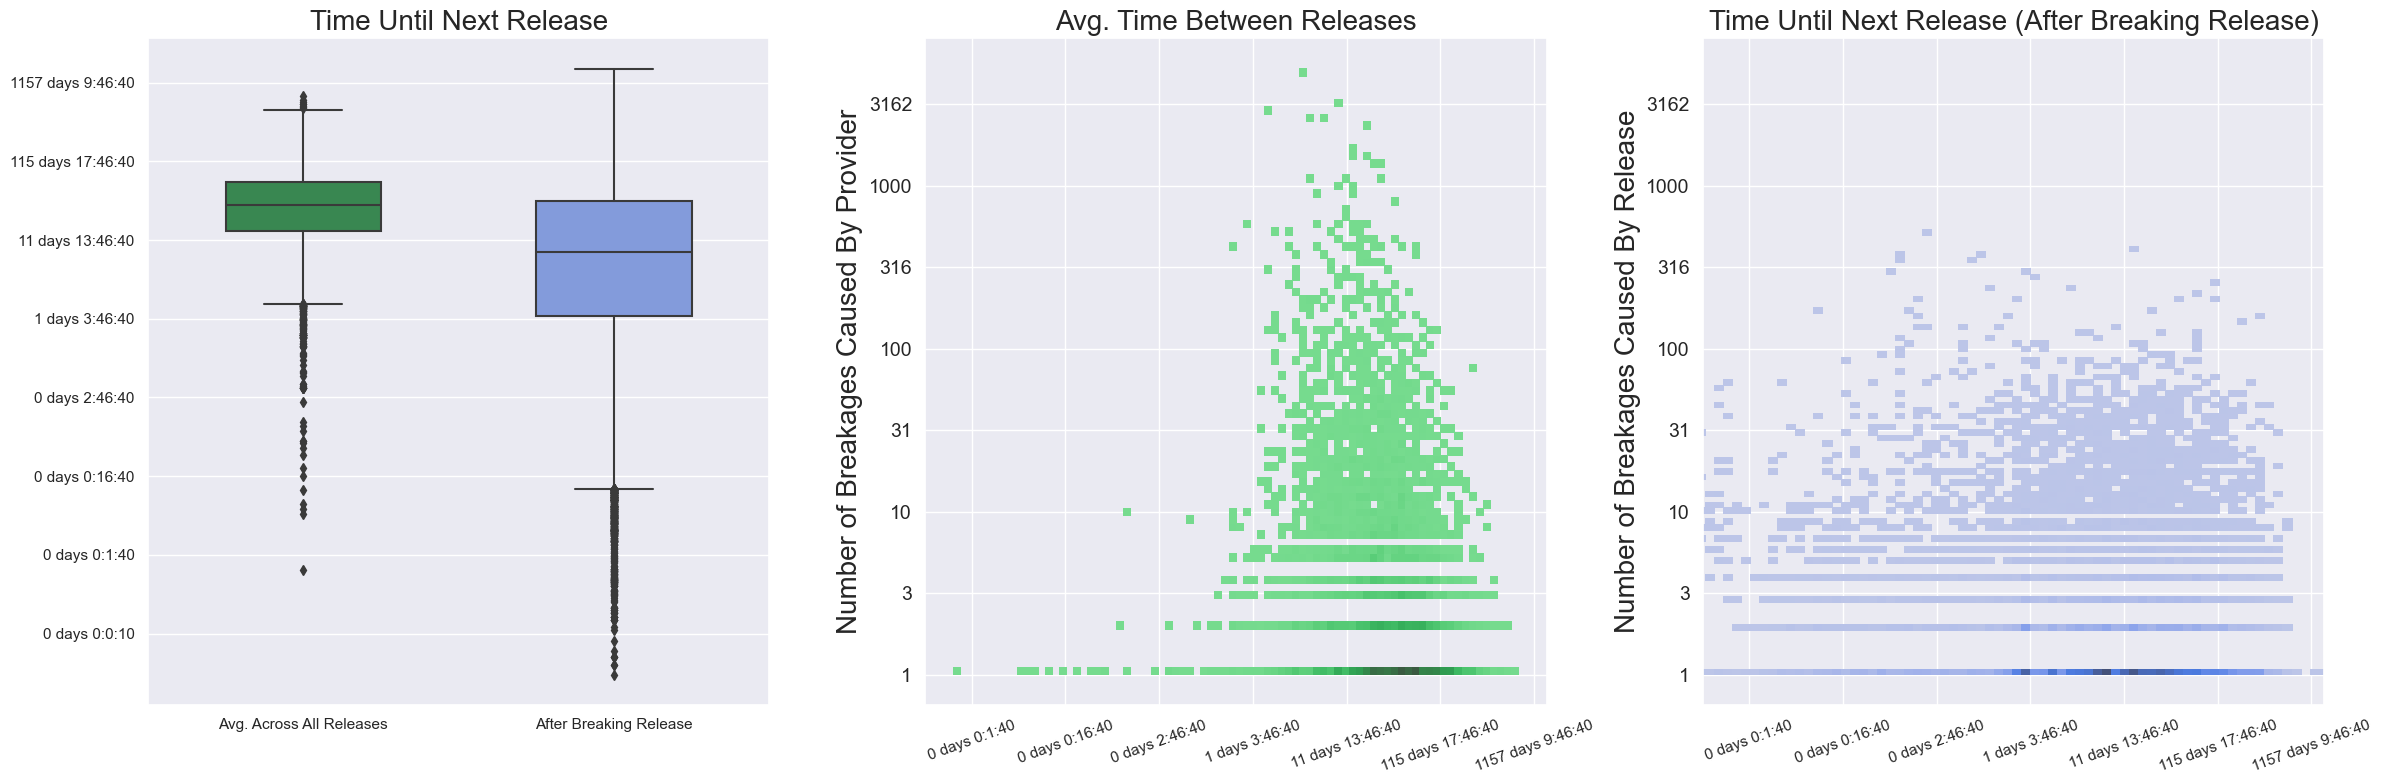

In [413]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for_boxplot = pd.DataFrame({
    'next_release_log_time': np.log10(next_releases['time_until_next_release'].astype('timedelta64[s]')),
    'type': 'After Breaking Release',
})
all_rel_times = pd.DataFrame({
    'next_release_log_time': np.log10(library_releases['avg_time_between_releases_seconds']).copy(),
    'type': 'Avg. Across All Releases',
})

for_boxplot = for_boxplot.append(all_rel_times)

params = dict(
    data=for_boxplot,
    y="next_release_log_time",
    x='type',
)
ax_1 = sns.boxplot(
    **params,
    ax=ax_1,
    order=['Avg. Across All Releases', 'After Breaking Release'],
    palette=TWO_COLOUR_PALETTE,
    width=0.5,
)
ax_1.set_title(f'Time Until Next Release', fontsize=20)
ax_1.set_ylabel('', fontsize=20)
ax_1.set_xlabel('', fontsize=20)
y_seconds = [10 ** x for x in ax_1.get_yticks()]
y_labels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(y_seconds, unit='s')]
ax_1.set_yticklabels(y_labels, rotation=0)


dropped_zero_time = library_releases[~(library_releases['avg_time_between_releases_seconds'] == 0)]
for_histplot_1 = pd.DataFrame({
    'next_release_log_time': np.log10(dropped_zero_time['avg_time_between_releases_seconds']),
    'log_breaks': np.log10(library_releases['broken_builds_caused']),
    'type': 'Avg. Across All Releases',
})
params_1 = dict(
    data=for_histplot_1,
    x="next_release_log_time",
    y="log_breaks",
)
ax_2 = create_hist_plot(params_1, ax_2, color=TWO_COLOUR_PALETTE[0])
ax_2.set_title(f'Avg. Time Between Releases', fontsize=20)
ax_2.set_ylabel('Number of Breakages Caused By Provider', fontsize=20)
ax_2.set_xlabel('', fontsize=20)
x_seconds = [10 ** x for x in ax_2.get_xticks()]
xlabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(x_seconds, unit='s')]
ax_2.set_xticklabels(xlabels, rotation=20)
ax_2.set_yticklabels([int(10 ** y) for y in ax_2.get_yticks()], size=14)


for_histplot_2 = pd.DataFrame({
    'next_release_log_time': np.log10(next_releases['time_until_next_release'].astype('timedelta64[s]')),
    'log_breaks': np.log10(next_releases['breaks_count']),
    'type': 'After Breaking Release',
})
params_2 = dict(
    data=for_histplot_2,
    x="next_release_log_time",
    y="log_breaks",
)

ax_3 = create_hist_plot(params_2, ax_3, color=TWO_COLOUR_PALETTE[1])
ax_3.set_ylim(ax_2.get_ylim())
ax_3.set_xlim(ax_2.get_xlim())
ax_3.set_title(f'Time Until Next Release (After Breaking Release)', fontsize=20)
ax_3.set_ylabel('Number of Breakages Caused By Release', fontsize=20)
ax_3.set_xlabel(f'', fontsize=20)
x_seconds = [10 ** x for x in ax_3.get_xticks()]
xlabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(x_seconds, unit='s')]
ax_3.set_xticklabels(xlabels, rotation=20)
ax_3.set_yticklabels([int(10 ** y) for y in ax_3.get_yticks()], size=14)

fig.tight_layout()
plt.show()

save_plot(fig, 'time_until_next_release_after_break_plots.png')

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-328-a8acd5a3477e>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(xlabels, rotation=20)
<ipython-input-328-a8acd5a3477e>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_yticklabels([int(10 ** y) for y in ax_2.get_yticks()], size=14)


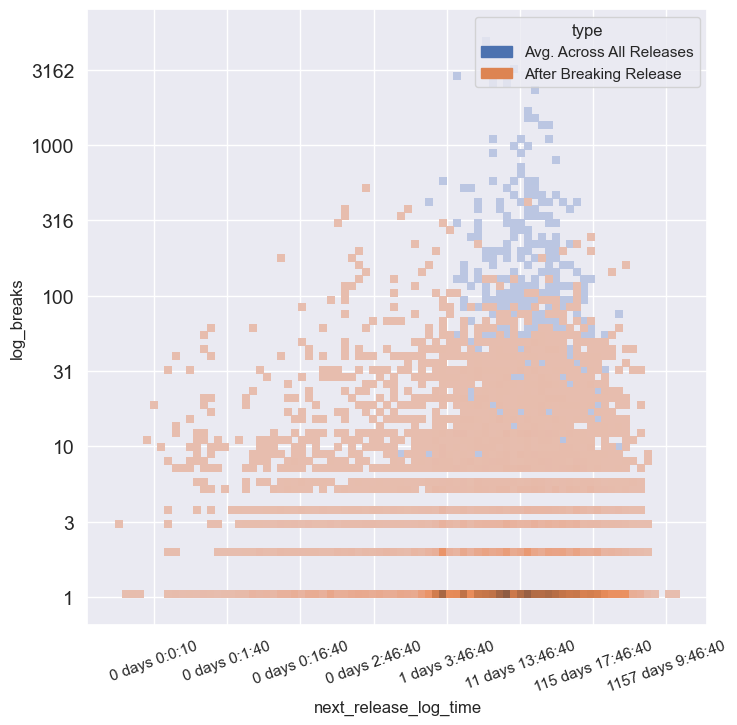

In [328]:
fig, ax_2 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

dropped_zero_time = library_releases[~(library_releases['avg_time_between_releases_seconds'] == 0)]
for_histplot = pd.DataFrame({
    'next_release_log_time': np.log10(dropped_zero_time['avg_time_between_releases_seconds']),
    'log_breaks': np.log10(library_releases['broken_builds_caused']),
    'type': 'Avg. Across All Releases',
})
temp = pd.DataFrame({
    'next_release_log_time': np.log10(next_releases['time_until_next_release'].astype('timedelta64[s]')),
    'log_breaks': np.log10(next_releases['breaks_count']),
    'type': 'After Breaking Release',
})
for_histplot = for_histplot.append(temp)

params = dict(
    data=for_histplot,
    x="next_release_log_time",
    y="log_breaks",
    hue="type",
)

ax_2 = create_hist_plot(params, ax_2)
x_seconds = [10 ** x for x in ax_2.get_xticks()]
xlabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(x_seconds, unit='s')]
ax_2.set_xticklabels(xlabels, rotation=20)
ax_2.set_yticklabels([int(10 ** y) for y in ax_2.get_yticks()], size=14)

plt.show()